# PCA of white dwarf spectra

We will use the library of white dwarf spectra from Pierre Bergeron. The origin is http://www.astro.umontreal.ca/~bergeron/CoolingModels/.  The first functions here read the spectra from this sample in.

To make this work you need to do two steps:

- Get the Datafiles/white-dwarfs.tar.gz file and unpack this in some location on your machine. 
- Modify the `load_one_wd_spectrum` function below so that `ROOT` gives the directory where you have unpacked the white dwarf files (including the WhiteDwarfs directory).

Note that the loading function does take a bit of time.


In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import seaborn as sns
import glob

%matplotlib inline

In [8]:
def load_one_wd_spectrum(logg, T, silent=False):
    """Load one WD spectrum
    
    logg: The log surface gravity of the white dwarf
    T: The temperature to read in.
    silent: If set to True, a failure to find a file will just return in
            a return value of None, no message is printed out.
            
    Return: A dictionary with two keys: Wavelength and Flux. The wavelength is in Angstrom.
    
    """
    # This location needs to be changed if you want to use this on your own machine.
    # You then need also to copy the files from this directory.
    # Alternatively, data is at ftp://ftp.strw.leidenuniv.nl/pub/apmechev/WD_DBDM/. 
    ROOT = '/Users/jarle/Teaching/WhiteDwarfs/'
    
    pattern = ROOT+"bergeron_He_*_{0:2d}.dat_{1:d}".format(np.int(10*logg), np.int(T))
    
    files = glob.glob(pattern)
    try:
        fname = files[0]
    except:
        if not silent:
            print("I did not find anything corresponding to logg={0:.1f}, T={1}".format(logg, T))
        fname = None
    
    if fname is None:
        t = None
    else:
        tall = Table().read(fname, format='ascii', header_start=1,
                         names=('Wavelength', 'Flux'))
        tall['Wavelength'] = tall['Wavelength']*10 # Convert to AA
        # I only extract the UV-optical region.
        t = tall[(tall['Wavelength'] > 900) & (tall['Wavelength'] < 1e4) ]
        
    return t
    
def assemble_library():
    """
    Assemble the library of White dwarf spectra.
    
    Returns a tuple with the wavelength in Ångström, the flux, the logg and T.
    """
    # Extracted from file names with:
    # ls bergeron_He_* | perl -ane '{($logg, $T) = ($_ =~ m/bergeron_He_[0-9]+_([0-9]+)\.dat_([0-9]+)/); print $logg, "\n";}' | sort | uniq
    # and similar for the temperature
    loggs = [7.0, 7.5, 8.0, 8.5, 9.0]
    
    Ts = Table().read('../../Datafiles/uniq.Ts', names=('T'), format='ascii',
                      data_start=0, )
    
    n_logg = len(loggs)
    n_T = len(Ts)
    n_tot = n_T*n_logg
    counter = 0
    first = True
    logg_vec = np.zeros(n_tot)
    T_vec = np.zeros(n_tot)
    for i_g, logg in enumerate(loggs):
        for i_T, row in enumerate(Ts):
            T = row['T']
            sp = load_one_wd_spectrum(logg, np.float(T), silent=True)
            if first:
                spec = np.zeros((len(sp['Wavelength']), n_tot))
                first = False
                wave = sp['Wavelength']
                
            if sp is None:
                # Some combinations of temperature and logg do not exist
                n_tot = n_tot-1 
                continue
                
            logg_vec[counter] = logg
            T_vec[counter] = T
            spec[:, counter] = sp['Flux']
            counter = counter+1
            
    return wave, spec[:, 0:n_tot].T, logg_vec[0:n_tot], T_vec[0:n_tot]
                
    
    

In [9]:
l, f, logg, T = assemble_library()

In [11]:
# It can be useful to see the size of these variables.
l.shape, f.shape, logg.shape, T.shape

((1807,), (530, 1807), (530,), (530,))

## Do PCA transform of the spectra

We are now going to do a PCA transform of the spectra. (Well below I also import NMF which you can try instead if you prefer).

In [12]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

### a) Visualisation

Before this it is useful to get some feeling for the data. This calculates the mean spectrum and shows a set of spectra. There are no units, no x/y-labels - just a plot to see what is going on. 

Modify the plot to make it larger and add a legend with the temperature of each model.

In [13]:
spec_mean = f.mean(0)

Text(0, 0.5, 'Flux')

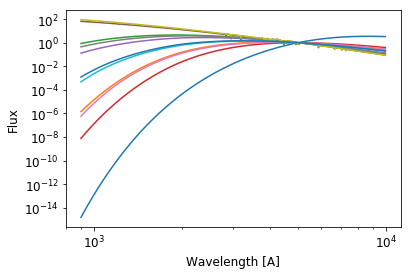

In [16]:
tmp = plt.loglog(l, f[0:530:50, :].T)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

### b) Start the PCA transformation.

The code below creates a PCA transformation of the spectra and does the basic look at the data. Your task is to determine how many components you need in order to reconstruct a spectrum to a certain precision, but along the way there are a couple of other tasks to do, listed below.

In [17]:
pca = PCA(n_components=10, whiten=True)

Do the PCA - you can experiment with subtracting off the mean, here I do not.

In [18]:
pca.fit(f)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

and then look at the explained variance - a lot in only one PCA - why is that?

<BarContainer object of 10 artists>

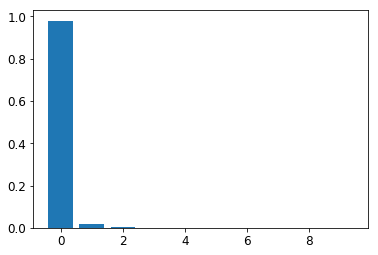

In [19]:
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

Now we calculate the individual principal components. 

**Task**: Show the first three eigenvectors (eigenspectra is what we normally call this in the literature).

**Task**: Plot the first five principal components in a pair plot or similar and colour the symbols with the log g. Repeat this and do it coloured by T. 

*Hint: Creating a data frame with the PCs and log g/T values might be a good approach. I used this and a call of the form sns.pairplot(dft, hue='logg', vars=('PC1', 'PC2', 'PC3', 'PC4')) for one plot. *

**Task**: Now, reconstruct a spectrum using the principal components and compare this to the input spectrum. If you subtracted the mean spectrum, do not forget to add it back in! *Hint: make sure to use the inverse transform*. Compare these and use this to decide how to determine the number of components to keep.

## Estimating PCA components using density estimators.

We can finally try to make new spectra from the old by taking the distribution of PCs that we derive from the spectral library and draw new PCs from these distributions. 

**Task**: Fit kernel density estimators to the distributions of each PC and draw a random spectrum. Does this give realistic looking spectra? Why? Why not?

In [ ]:
from sklearn.neighbors import KernelDensity